# Deep Learning Project

### Authored by Anurag Ramesh Patil, Bijay Gautham, Justin Gamoras, Sara Hart, Shri Hari Sekar, Suyog Sanklapur

**Initial Folder Structure:**

    project/
    ├─ project.ipynb
    ├─ dataset/
    │  ├─ train
    │  ├─ test


**New Folder Structure:**

    project/
    ├─ project.ipynb
    ├─ dataset/
    │  ├─ train
    │  ├─ test
    │  ├─ train_new
    │  ├─ test_new
    │  ├─ cross_new


<hr>

## Installing Dependencies

In [1]:
# Install scikit-learn
%pip install scikit-learn
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

<hr>

## Move and create new folders for train, test and cross-validation with appropriate labels

In [3]:
# Define paths to your original train and test folders
original_train_folder = 'Driver-Drowsiness-Dataset/train'
original_test_folder = 'Driver-Drowsiness-Dataset/test'

In [4]:
# Define new paths for the split datasets
training_set_folder = 'Driver-Drowsiness-Dataset/train_new'
crossval_set_folder = 'Driver-Drowsiness-Dataset/cross_new'
test_set_folder = 'Driver-Drowsiness-Dataset/test_new'

In [5]:
# Ensure the new folders are created
os.makedirs(training_set_folder, exist_ok=True)
os.makedirs(crossval_set_folder, exist_ok=True)
os.makedirs(test_set_folder, exist_ok=True)

In [6]:
# Function to get all files in a given folder and its sub-folders
def get_all_files_in_folder(folder):
    """Returns a list of all file paths in the given folder, including sub-folders."""
    all_files = []
    for root, _, files in os.walk(folder):
        for file in files:
            all_files.append(os.path.join(root, file))
    return all_files

In [7]:
# Get all files from the original train and test folders
train_files = get_all_files_in_folder(original_train_folder)
test_files = get_all_files_in_folder(original_test_folder)

In [8]:
print("\nTrain Files", train_files)
print("\nTest Files", test_files)


Train Files ['Driver-Drowsiness-Dataset/train\\Closed\\_0.jpg', 'Driver-Drowsiness-Dataset/train\\Closed\\_1.jpg', 'Driver-Drowsiness-Dataset/train\\Closed\\_10.jpg', 'Driver-Drowsiness-Dataset/train\\Closed\\_100.jpg', 'Driver-Drowsiness-Dataset/train\\Closed\\_101.jpg', 'Driver-Drowsiness-Dataset/train\\Closed\\_102.jpg', 'Driver-Drowsiness-Dataset/train\\Closed\\_103.jpg', 'Driver-Drowsiness-Dataset/train\\Closed\\_104.jpg', 'Driver-Drowsiness-Dataset/train\\Closed\\_105.jpg', 'Driver-Drowsiness-Dataset/train\\Closed\\_106.jpg', 'Driver-Drowsiness-Dataset/train\\Closed\\_108.jpg', 'Driver-Drowsiness-Dataset/train\\Closed\\_109.jpg', 'Driver-Drowsiness-Dataset/train\\Closed\\_11.jpg', 'Driver-Drowsiness-Dataset/train\\Closed\\_110.jpg', 'Driver-Drowsiness-Dataset/train\\Closed\\_111.jpg', 'Driver-Drowsiness-Dataset/train\\Closed\\_112.jpg', 'Driver-Drowsiness-Dataset/train\\Closed\\_113.jpg', 'Driver-Drowsiness-Dataset/train\\Closed\\_114.jpg', 'Driver-Drowsiness-Dataset/train\\Clos

In [9]:
# Combine the files to get a full dataset
all_files = train_files + test_files

In [10]:
# Split into Training Set (~60%) and Remaining Set (~40%)
train_files_60, remaining_files_40 = train_test_split(all_files, test_size=0.4, random_state=42)

In [11]:
# Split the remaining set into Cross-validation Set (~20%) and Test Set (~20%)
crossval_files_20, test_files_20 = train_test_split(remaining_files_40, test_size=0.5, random_state=42)

In [12]:
# Function to move files to a specified folder while maintaining sub-folder structure
def move_files_to_folder(files, destination_folder):
    """Moves a list of files to the specified destination folder, retaining sub-folder structure."""
    for file in files:
        # Get the relative path from the original folder
        relative_path = os.path.relpath(file, original_train_folder if file in train_files else original_test_folder)
        destination_path = os.path.join(destination_folder, relative_path)

        # Ensure the sub-folder structure is created
        os.makedirs(os.path.dirname(destination_path), exist_ok=True)

        # Move the file
        shutil.move(file, destination_path)

In [13]:
# Move the files to the respective folders
move_files_to_folder(train_files_60, training_set_folder)
move_files_to_folder(crossval_files_20, crossval_set_folder)
move_files_to_folder(test_files_20, test_set_folder)

In [14]:
# Output the number of files in each set for verification
print("Training set:", len(train_files_60))
print("Cross-validation set:", len(crossval_files_20))
print("Test set:", len(test_files_20))

Training set: 1740
Cross-validation set: 580
Test set: 580


## Image processing - CNN

In [15]:
# Image size to which we will resize all images
IMG_SIZE = (64, 64)  # You can adjust as needed

> Change the image size if needed

In [16]:
# Function to load and process images from a given folder
def load_images_from_folder(folder):
    """Loads images and labels from a given folder with sub-folders representing classes."""
    images = []
    labels = []
    for root, _, files in os.walk(folder):
        class_name = os.path.basename(root)  # Use sub-folder names as class labels
        label = {
            'yawn': 1,  # drowsy
            'no_yawn': 0,  # not drowsy
            'Open': 0,  # eyes open (not drowsy)
            'Closed': 1,  # eyes closed (drowsy)
        }.get(class_name, -1)  # Default to -1 if unknown class
        if label == -1:
            continue
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(root, file)
                img = tf.keras.utils.load_img(img_path, target_size=IMG_SIZE)
                img = tf.keras.utils.img_to_array(img)
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)

In [17]:
# Load datasets
X_train, y_train = load_images_from_folder(training_set_folder)
X_crossval, y_crossval = load_images_from_folder(crossval_set_folder)
X_test, y_test = load_images_from_folder(test_set_folder)

In [18]:
# Normalize the pixel values
X_train = X_train / 255.0
X_crossval = X_crossval / 255.0
X_test = X_test / 255.0

In [19]:
# Define a simple CNN model for binary classification
model = Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout to reduce overfitting
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

c:\Users\sanga\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [20]:
# Compile the model with an appropriate optimizer and loss function
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
# Train the model with validation on the cross-validation set
history = model.fit(X_train, y_train, validation_data=(X_crossval, y_crossval), epochs=10, batch_size=32)

Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.5312 - loss: 0.7197 - val_accuracy: 0.7776 - val_loss: 0.5016
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.7454 - loss: 0.5305 - val_accuracy: 0.8224 - val_loss: 0.3603
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.7663 - loss: 0.4351 - val_accuracy: 0.8500 - val_loss: 0.3076
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.7861 - loss: 0.3973 - val_accuracy: 0.8224 - val_loss: 0.3091
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.8047 - loss: 0.3594 - val_accuracy: 0.8483 - val_loss: 0.2785
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.8337 - loss: 0.3217 - val_accuracy: 0.8569 - val_loss: 0.2705
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.8201 - loss: 0.3228 - val_accuracy: 0.8621 - val_loss: 0.2589
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.8402 - loss: 0.2936 - val_accuracy: 0.8603 - v

In [22]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9312 - loss: 0.1674
Test Loss: 0.24132218956947327
Test Accuracy: 0.8637930750846863


In [23]:
model.save('cnn_model.h5')

In [24]:
# Generate a classification report and confusion matrix for the test set
y_pred = (model.predict(X_test) > 0.5).astype(int)
print("Classification Report:\n", classification_report(y_test, y_pred))
confusion_matrix_test = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", confusion_matrix_test)

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.96      0.87       281
           1       0.95      0.78      0.85       299

    accuracy                           0.86       580
   macro avg       0.88      0.87      0.86       580
weighted avg       0.88      0.86      0.86       580

Confusion Matrix:
 [[269  12]
 [ 67 232]]


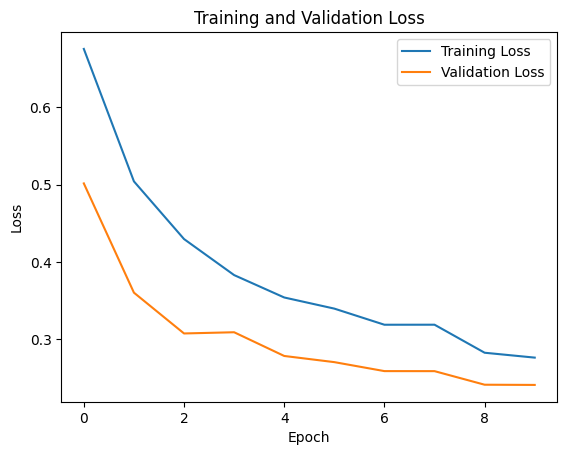

In [25]:
# Plot the training and validation loss/accuracy to visualize model performance
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

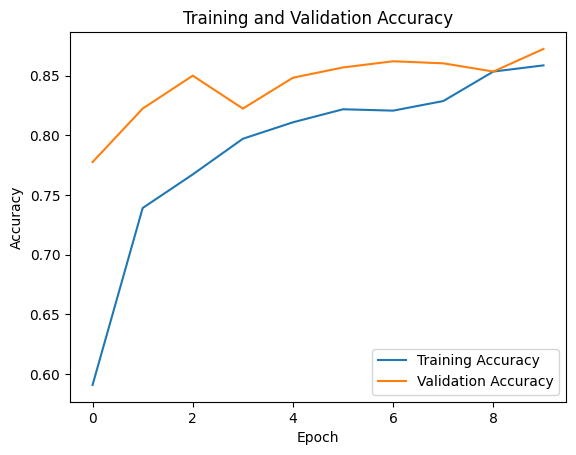

In [26]:
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

> Develop a interface for our model - either by creating a live camera view to detect drowsiness or by creating an interface to upload user images and to detect the class

> For interface - check the interface.py (Python File) under files

> To run it in locally in VSCode - Download both interface.py and cnn_model.h5

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=26b1babe-62ce-47f0-aa8b-3e96bd5669ca' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>